In [1]:
import os
os.chdir('../..')
import ml_collections
import yaml
from Nbody.utils import model_path
from Nbody.models import get_model
import torch
from Nbody.dataloader import get_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [2]:
with open('Nbody/train.yaml') as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))

In [4]:
# load lstm_dev_SE model
config.model = 'LSTM_development'
config.param = 'SE'
config.comment = 'best'
config.gpu_id = '1'
config.train = False
#config.p = 30
model_path(config)
LSTM_dev_SE = get_model(config)
LSTM_dev_SE.load_state_dict(torch.load(config.path), strict=False)
LSTM_dev_SE=LSTM_dev_SE.to(config.device)

Number of parameters: 16192
GPU's available: 5


In [5]:
# load lstm model
config.model = 'LSTM'
config.param = 'SE'
config.comment = 'best'
config.train = False
model_path(config)
LSTM = get_model(config)
LSTM.load_state_dict(torch.load(config.path), strict=False)
LSTM = LSTM.to(config.device)

Number of parameters: 16330
GPU's available: 5


In [6]:
# load dataset
dataloaders, test_loader = get_dataset(config)

In [7]:
inputs,outputs,LSTM_dev_out,LSTM_out = [], [], [], []
with torch.no_grad():
    for i,(x,y) in enumerate(test_loader):
        #print(i)
        x = x.to(config.device)
        inputs.append(x)
        outputs.append(y)
        LSTM_dev_out.append(LSTM_dev_SE(x))
        LSTM_out.append(LSTM(x))


In [8]:
inputs,outputs = torch.cat(inputs).detach().cpu().numpy(),torch.cat(outputs)
LSTM_dev_out = torch.cat(LSTM_dev_out)
LSTM_out = torch.cat(LSTM_out)

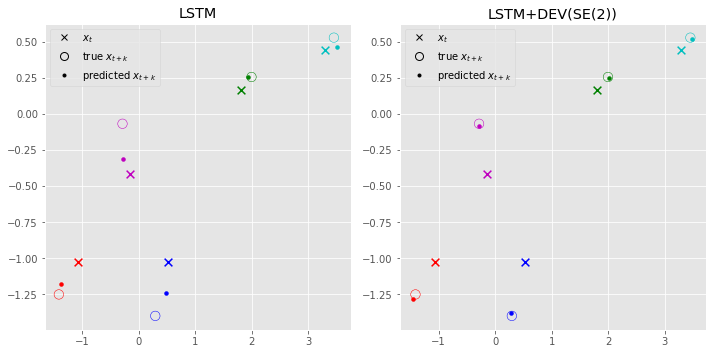

In [11]:
idx = 26150
#input_path,output = inputs[i,...,:2], outputs[i,...]

plt.style.use('ggplot')
observed = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=6, label='$x_t$')
true = mlines.Line2D([], [], color='black',  markerfacecolor='none',marker='o', linestyle='None',
                          markersize=8, label='true $x_{t+k}$')
pred = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                          markersize=6, label='predicted $x_{t+k}$')


fig, axes = plt.subplots(1,2)
fig.set_size_inches(10, 5)
colors = ['r','b','c','g','m'] 
for i in range(5):
    
    axes[0].scatter(inputs[idx,-1,i,0],inputs[idx,-1,i,1],color = colors[i],marker='x',s=60)
    axes[0].scatter(outputs[idx,i,0],outputs[idx,i,1],color = colors[i],s=90,
                facecolors='none', edgecolors=colors[i])
    axes[0].scatter(LSTM_out.detach().cpu().numpy()[idx,i,0],
                LSTM_out.detach().cpu().numpy()[idx,i,1],color = colors[i],marker='.',s=60)
axes[0].legend(handles=[observed, true, pred])
x0,x1 = axes[0].get_xlim()
y0,y1 = axes[0].get_ylim()
axes[0].set_aspect(abs(x1-x0)/abs(y1-y0))
axes[0].set_title('LSTM')
for i in range(5):
    
    axes[1].scatter(inputs[idx,-1,i,0],inputs[idx,-1,i,1],color = colors[i],marker='x',label='last observed x-y',s=60)
    axes[1].scatter(outputs[idx,i,0],outputs[idx,i,1],color = colors[i],s=90,
                facecolors='none', edgecolors=colors[i],label='output x-y')
    axes[1].scatter(LSTM_dev_out.detach().cpu().numpy()[idx,i,0],
                LSTM_dev_out.detach().cpu().numpy()[idx,i,1],color = colors[i],marker='.',label='predicted x-y',s=60)
axes[1].legend(handles=[observed, true, pred])
x0,x1 = axes[1].get_xlim()
y0,y1 = axes[1].get_ylim()
axes[1].set_aspect(abs(x1-x0)/abs(y1-y0))
#ax.grid(b=True, which='major', color='k', linestyle='--')
axes[1].set_title('LSTM+DEV(SE(2))')
fig.tight_layout()
plt.show()
fig.savefig('Nbody/notebooks/Nbody_plot.png',format='png',dpi=350)
#fig.savefig('Nbody/notebooks/Nbody_LSTM_dev.png',format='png',dpi=350)


